# Gather data

## RDF

In [1]:
import re
import h5py
import iopublic
import numpy as np

PAT = r'_([01][^_]*)_([01]\.[0-9])_'

r = np.linspace(0, 1000, 200)
dr = r[1] - r[0]

def go(simdata, network):
    pos = np.array([(n.x, n.y, n.z) for n in network.neurons])
    sync = np.array(simdata['sync']) # gid, gjd, tfrom, tto, z
    rdf = np.zeros_like(r) # synchronization distribution
    rdf0 = np.zeros_like(r) # position distribution
    rs = np.linalg.norm(pos[sync[:,0].astype(int)] - pos[sync[:,1].astype(int)], axis=1)
    rs0 = np.linalg.norm(pos[:,np.newaxis,:] - pos[np.newaxis, :, :], axis=2).flatten()
    for dist, length in zip(rs, sync[:,3] - sync[:,2]):
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf[idx] += length
    for dist in rs0:
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf0[idx] += 20000
    rdf0[0] = 1
    rdf = rdf / rdf0
    rdf[0] = 0
    return rdf

with h5py.File('imgdata/rdf.h5', 'w') as fout:
    f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
    for tuning in f.keys():
        network = iopublic.get_network_for_tuning(tuning)
        for env in f[tuning].keys():
            print('.', flush=True, end='')
            simdata = f[tuning][env]
            if 'sync' not in simdata:
                continue
            rdf = go(simdata, network)
            fout.create_dataset(f'{tuning}/{env}/rdf', data=rdf)
            fout.create_dataset(f'{tuning}/{env}/r', data=r)
            m = re.search(PAT, tuning)
            ggap = float(m.group(1))
            coef = float(m.group(2))
            fout.create_dataset(f'{tuning}/{env}/ggap', data=ggap)
            fout.create_dataset(f'{tuning}/{env}/coef', data=coef)

....................................................................................................................................

# Plotting

## Synchronization (RDF)

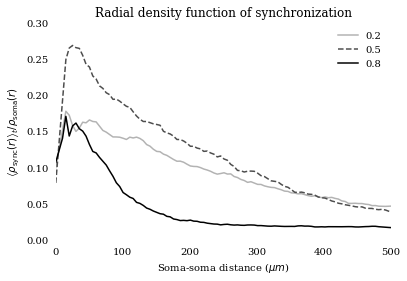

In [41]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

plt.rc('font', family='serif')

keys = '''021-12-08-shadow_averages_0.01_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
2021-12-08-shadow_averages_0.01_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
2021-12-08-shadow_averages_0.01_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a
2021-12-08-shadow_averages_0.01_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc
2021-12-08-shadow_averages_0.01_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf
2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86
2021-12-08-shadow_averages_0.01_0.6_b07556b1-21fa-47e6-9021-20072df022c6
2021-12-08-shadow_averages_0.01_0.7_ff526814-9232-4074-8473-16a99676c3ab
2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be
2021-12-08-shadow_averages_0.01_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41
2021-12-08-shadow_averages_0.01_1.0_751ac228-3e2f-4d28-9894-6972386c6977'''.splitlines()

f = h5py.File('imgdata/rdf.h5', 'r')
selected = [2,5,8]
kwargs = [
    dict(color='0.7', ls='solid'),
    dict(color='0.3', ls='dashed'),
    dict(color='k', ls='solid')
]
for i, kw in zip(selected, kwargs):
    rdf = np.array(f[f'{keys[i]}/none/rdf'])
    rdf2 = savgol_filter(rdf, 5, 1)
    r = np.array(f[f'{keys[i]}/none/r'])
    ggap = np.array(f[f'{keys[i]}/none/ggap']).item()
    coef = np.array(f[f'{keys[i]}/none/coef']).item()
    #rdf[0] = np.nan
    plt.plot(r, rdf2, label=f'{coef}', **kw)
plt.xlabel('Soma-soma distance ($\\mu m$)')
plt.ylabel(r'$\left<\rho_{\mathrm{sync}}(r)\right>_t / \rho_{\mathrm{soma}}(r)$')
plt.legend(frameon=False)
plt.ylim([0, 0.3])
plt.xlim([0, 500])
plt.title('Radial density function of synchronization')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(bottom = False, left=False)

# Synchronization (sync)

In [172]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
tuning = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
#tuning = '2021-12-08-shadow_averages_0.001_1.0_751ac228-3e2f-4d28-9894-6972386c6977'
network = iopublic.get_network_for_tuning(tuning)
sync = np.array(f[tuning]['none']['sync'])

Text(0, 0.5, 'Neuron (gid)')

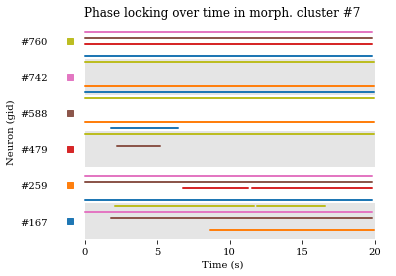

In [181]:
selected = 7

plt.rc('font', family='serif')

C = np.array([neuron.cluster for neuron in network.neurons])
#C = np.random.permutation(C)
mask = (C[sync[:,0].astype(int)] == selected) & (C[sync[:,1].astype(int)] == selected)
i, j, s, t = sync[mask, :4].astype(int).T
neurons = list(sorted(set(i) | set(j)))
ii = np.array([neurons.index(x) for x in i])
jj = np.array([neurons.index(x) for x in j])

#plt.figure(figsize=(14, 10))

cmap = plt.get_cmap('tab10')

def getc(i):
    return cmap(i / len(neurons))
    if i % 2 == 0:
        return '0.9'
    return 'white'

ticks = []
ticklabels = []

for idx, I in enumerate(neurons):
    #plt.axhline(idx*I0, color='black', lw=1)
    I0 = len(neurons)
    ticks.append(I0*idx + I0 / 2)
    ticklabels.append(f'#{I}')
    plt.plot(-1, idx*I0 + I0/2, 's', color=getc(idx))
    if idx % 2 == 0:
        plt.fill_between([0, 20], [I0*idx, I0*idx], [I0*idx+I0, I0*idx+I0], color='black', alpha=0.1, edgecolor="none")
    for jdx, J in enumerate(neurons):
        m = (i == I) & (j == J)
        for ss, tt in zip(s[m], t[m]):
            plt.plot([ss/1e3, tt/1e3], [0.5+I0*idx + jdx, 0.5+I0*idx + jdx], color=getc(jdx), lw=2, solid_capstyle='round')
#plt.axhline(idx*I0+I0, color='black', lw=1)

#plt.axvline(0, color='black', lw=1)

plt.yticks(ticks, ticklabels)
plt.ylim([ticks[0]-I0/2-0.1, ticks[-1]+I0/2+0.1])      
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(left=False)

plt.title(f'Phase locking over time in morph. cluster #{selected}')
plt.xlabel('Time (s)')
plt.ylabel('Neuron (gid)')

[14, 623, 731, 733, 799]